In [2]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow import Zero, One, I, X, Y, Z, SummedOp, PauliOp
from qiskit.circuit import Parameter, ParameterVector
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

### Declare parameters

In [3]:
import numpy as np
import os

num_sites = 4
tc = 0.5
eps = np.zeros(num_sites)
phi = 2*np.pi
phiL = -phi / 2
phiR = phi / 2
delta = np.array([np.exp(1j * phiL), np.exp(1j * phiR)])
t = np.ones(2)

initial_state = One ^ Zero ^ Zero ^ Zero
ket = "ket1000"
# Savefigure
if np.array_equal(t, delta):
    base_path = f"figures/2-site-coupling/trotter/eps={eps},t=delta,delta=[exp(iphiL),exp(iphiR)],tc={tc}_{ket}/"
else:
    base_path = f"figures/2-site-coupling/trotter/(eps={eps},t={t},delta=[exp(iphiL),exp(iphiR)],tc={tc}_{ket}/"

# Create folder if it doesn't exist
os.makedirs(base_path, exist_ok=True)
print(base_path)

figures/2-site-coupling/trotter/(eps=[0. 0. 0. 0.],t=[1. 1.],delta=[exp(iphiL),exp(iphiR)],tc=0.5_ket1000/


#### Compute Hamiltonian in Little Endian Notation

In [ ]:
def compute_H(eps, t, delta, tc, phiL, phiR, num_sites):
    H = 0
    # On-site terms
    for i in range(num_sites):
        H += eps[i] / 2 * ((I ^ num_sites) - ((I ^ (num_sites - i - 1)) ^ Z ^ (I ^ i)))

    # Coupling term (qubits 2 and 1)
    H += tc / 2 * ((I ^ X ^ X ^ I) + (I ^ Y ^ Y ^ I))

    if np.array_equal(t,delta):
        H += 1 / 2 * np.cos(phiL*np.pi/180)*((I ^ I ^ X ^ X))
        H += 1 / 2 * np.cos(phiR*np.pi/180)*((X ^ X ^ I ^ I))
    else:
        #Left term
        H += t[0] / 2 * ((X ^ X ^ I ^ I) + (Y ^ Y ^ I ^ I))
        H += 1 / 2 * np.cos(phiL*np.pi/180)*((I ^ I ^ X ^ X) - (I ^ I ^ Y ^ Y))
        H += 1 / 2 * np.sin(phiL*np.pi/180)*((I ^ I ^ X ^ X) + (I ^ I ^ Y ^ Y))

        H += t[1] / 2 * ((I ^ I ^ X ^ X) + (I ^ I ^ Y ^ Y))
        H += 1 / 2 * np.cos(phiR*np.pi/180)*((X ^ X ^ I ^ I) - (Y ^ Y ^ I ^ I))
        H += 1 / 2 * np.sin(phiR*np.pi/180)*((X ^ X ^ I ^ I) + (Y ^ Y ^ I ^ I))

    return H

# Parameterized hopping strengths
eps_param = ParameterVector("ε", num_sites)
t_param = ParameterVector("t",2)
tc_param = Parameter("tc")
delta_param = ParameterVector("Δ",2)
phiR_param = Parameter("phiR")
phiL_param = Parameter("phiL")


H_param = compute_H(eps_param, t_param, delta_param,tc_param, phiR_param, phiL_param, num_sites)

# Select specific t and t_c values
H = H_param.bind_parameters({eps_param: eps, t_param: t, tc_param: tc, delta_param: delta, phiR_param: phiR, phiL_param: phiL})
H

def compute_H_secondquant_normal(eps, tc, t, delta):
    second_quant_H = 0
    second_quant_H += eps[0] * ( FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += eps[1] * ( FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(1)))    
    second_quant_H += t[0] * (FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(1)))
    second_quant_H += np.conjugate(t[0]) * (FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += delta[0] * (FermionicOp("+_{}".format(0)) @ FermionicOp("+_{}".format(1)))
    second_quant_H += np.conjugate(delta[0]) * (FermionicOp("-_{}".format(1)) @ FermionicOp("-_{}".format(0)))

    second_quant_H += tc * (FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += tc * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(1)))

    second_quant_H += eps[2] * ( FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += eps[3] * ( FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += t[1] * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += np.conjugate(t[1]) * (FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += delta[1] * (FermionicOp("+_{}".format(2)) @ FermionicOp("+_{}".format(3)))
    second_quant_H += np.conjugate(delta[1]) * (FermionicOp("-_{}".format(3)) @ FermionicOp("-_{}".format(2)))

    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

H = compute_H_secondquant_normal(eps, tc, t, delta)

SummedOp([PauliSumOp(SparsePauliOp(['IIII', 'IIIZ'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.0), PauliSumOp(SparsePauliOp(['IIII', 'IIZI'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.0), PauliSumOp(SparsePauliOp(['IIII', 'IZII'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.0), PauliSumOp(SparsePauliOp(['IIII', 'ZIII'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.0), PauliSumOp(SparsePauliOp(['IXXI', 'IYYI'],
              coeffs=[1.+0.j, 1.+0.j]), coeff=0.25), PauliSumOp(SparsePauliOp(['XXII', 'YYII'],
              coeffs=[1.+0.j, 1.+0.j]), coeff=0.5), PauliSumOp(SparsePauliOp(['IIXX', 'IIYY'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.4992485749319319), PauliSumOp(SparsePauliOp(['IIXX', 'IIYY'],
              coeffs=[1.+0.j, 1.+0.j]), coeff=0.027401832574394765), PauliSumOp(SparsePauliOp(['IIXX', 'IIYY'],
              coeffs=[1.+0.j, 1.+0.j]), coeff=0.5), PauliSumOp(SparsePauliOp(['XXII', 'YYII'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0

### Import observables

In [22]:
#Number operator
from operators import n_op, p_op, cc_nb_op, cc_edge_op, cc_site_op

n_is = n_op(num_sites)
p_is = p_op(num_sites)
cc_is_00 = cc_site_op(num_sites)
cc_nb_is_01 = cc_nb_op(num_sites,0,1)
cc_nb_is_12 = cc_nb_op(num_sites,1,2)
cc_nb_is_23 = cc_nb_op(num_sites,2,3)
cc_edge_is = cc_edge_op(num_sites, 0, 3)

### Classical simulation

In [23]:
#Parameters for simulation
times = np.linspace(0, 8 * np.pi, 500)


In [24]:
from functions import exact_time_evolution

n_evo_matrix, n_var_matrix = exact_time_evolution(H, n_is, initial_state, times, num_sites)
p_evo_matrix, p_var_matrix = exact_time_evolution(H, p_is, initial_state, times, num_sites)
cc_nb_evo_matrix_00, cc_nb_var_matrix_00 = exact_time_evolution(H, cc_is_00, initial_state, times, num_sites)
cc_nb_evo_matrix_01, cc_nb_var_matrix_01 = exact_time_evolution(H, cc_nb_is_01, initial_state, times, num_sites)
cc_nb_evo_matrix_12, cc_nb_var_matrix_12 = exact_time_evolution(H, cc_nb_is_12, initial_state, times, num_sites)
cc_nb_evo_matrix_23, cc_nb_var_matrix_23 = exact_time_evolution(H, cc_nb_is_12, initial_state, times, num_sites)
cc_edge_evo_matrix, cc_edge_var_matrix = exact_time_evolution(H, cc_edge_is, initial_state, times, num_sites)

 39%|███▊      | 193/500 [00:10<00:16, 18.96it/s]


KeyboardInterrupt: 

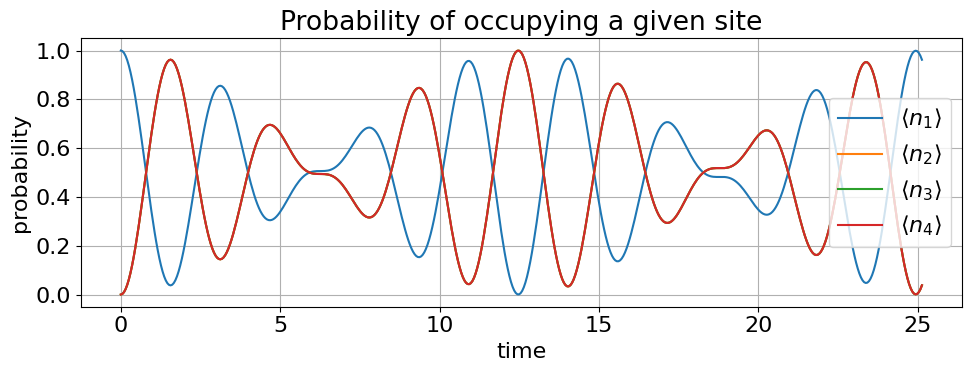

In [ ]:
# Plot the time evolution
# list of labels for the plot
num_op_labels = [r"$\langle n_" + str(i+1) + "\\rangle$" for i in range(num_sites)]
path = base_path + "2-site-coupling-prob.pdf"

plt.figure(figsize=(10, 4))
plt.plot(times, n_evo_matrix)
plt.xlabel("time")
plt.ylabel("probability")
plt.title("Probability of occupying a given site")
plt.grid()
plt.legend(num_op_labels)
plt.tight_layout()
plt.savefig(path)
plt.show()

#### Particle and parity conservation check

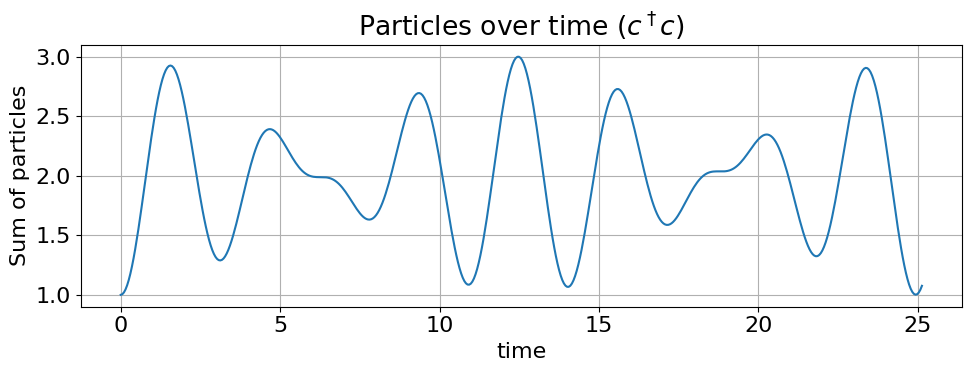

In [ ]:
path = base_path + "2-site-coupling-particle-count.pdf"

plt.figure(figsize=(10, 4))
plt.plot(times, np.sum(n_evo_matrix, axis=1))
plt.xlabel("time")
plt.ylabel("Sum of particles")
plt.title("Particles over time ($c^\dagger c$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

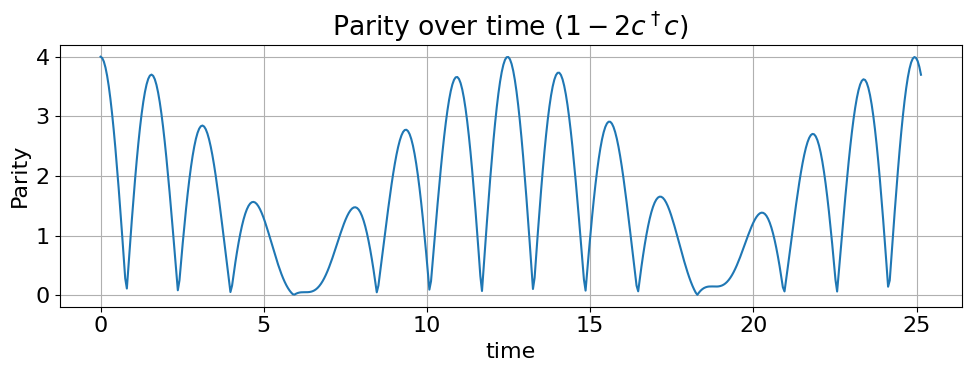

In [ ]:
path = base_path + "2-site-coupling-parity-count.pdf"

plt.figure(figsize=(10, 4))
plt.plot(times, np.sum(p_evo_matrix, axis=1))
plt.xlabel("time")
plt.ylabel("Parity")
plt.title(r"Parity over time ($1-2c^\dagger c$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

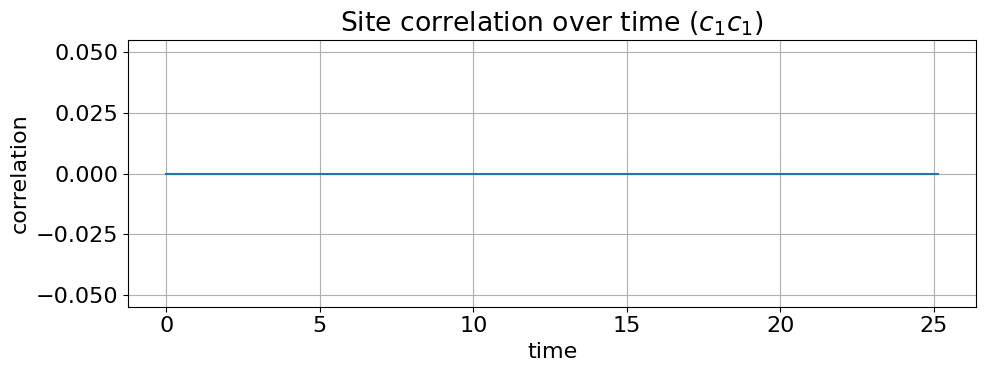

In [ ]:
path = base_path + "2-site-coupling-corr_nb_11.pdf"

plt.figure(figsize=(10, 4))
plt.plot(times, np.sum(cc_nb_evo_matrix_00, axis=1))
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Site correlation over time ($c_1 c_1$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

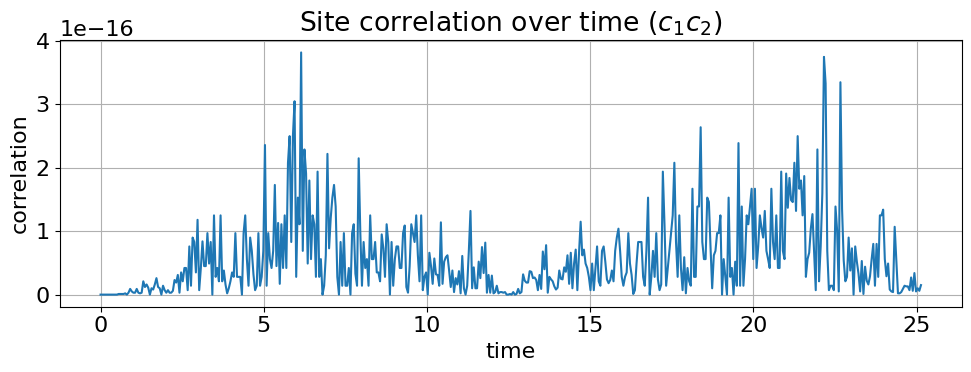

In [ ]:
path = base_path + "2-site-coupling-corr_nb_12.pdf"

plt.figure(figsize=(10, 4))
plt.plot(times, np.sum(cc_nb_evo_matrix_01, axis=1))
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Site correlation over time ($c_1 c_2$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

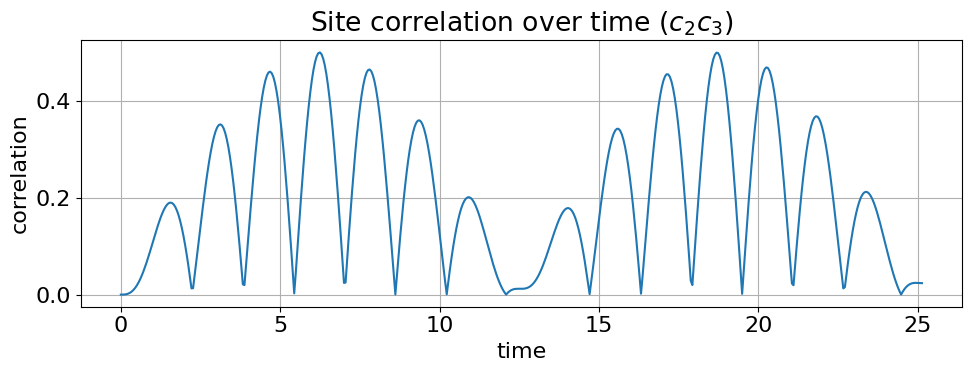

In [ ]:
path = base_path + "2-site-coupling-corr_nb_23.pdf"

plt.figure(figsize=(10, 4))
plt.plot(times, np.sum(cc_nb_evo_matrix_12, axis=1))
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Site correlation over time ($c_2 c_3$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

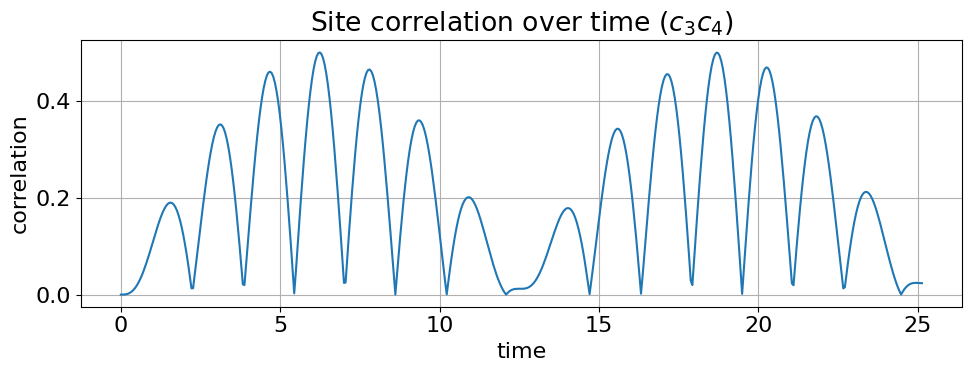

In [ ]:
path = base_path + "2-site-coupling-corr_nb_34.pdf"

plt.figure(figsize=(10, 4))
plt.plot(times, np.sum(cc_nb_evo_matrix_23, axis=1))
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Site correlation over time ($c_3 c_4$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

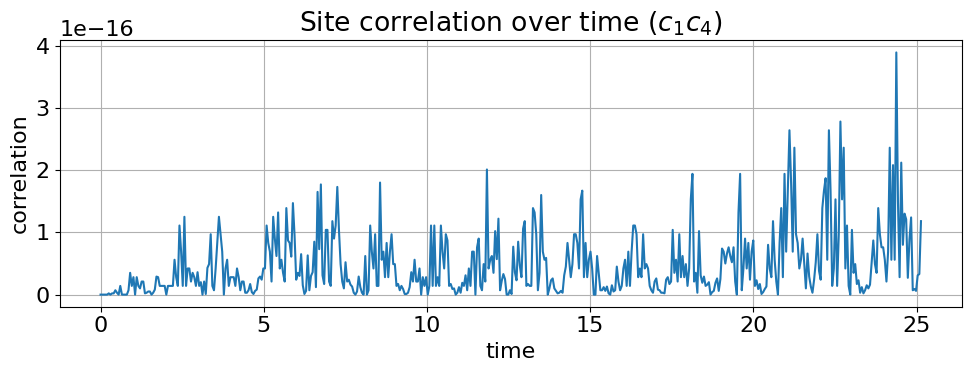

In [ ]:
path = base_path + "2-site-coupling-corr-edge.pdf"

plt.figure(figsize=(10, 4))
plt.plot(times, np.sum(cc_edge_evo_matrix, axis=1))
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Site correlation over time ($c_1 c_4$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

### Trotterization

100%|██████████| 4/4 [1:01:05<00:00, 916.40s/it]


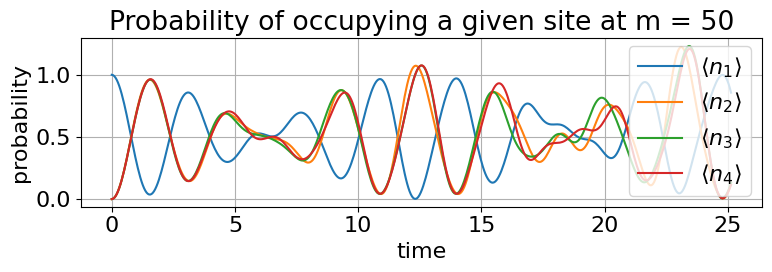

In [ ]:
# import sys
# sys.exit("Stopping here")
# Time evolution calculation using same parameters as the exact classical calculation
from functions import trotter_evolution

# Number of trotter steps
trotter_steps = 50

# Calculate each number operator's expectation value at each time point and store in a 2D array
n_evo_matrix_trot = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps)

# Plot the time evolution
path = base_path + "2-site-coupling-prob-trotter.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, n_evo_matrix_trot)
plt.xlabel("time")
plt.ylabel("probability")
plt.title(f"Probability of occupying a given site at m = {trotter_steps}")
plt.grid()
plt.legend(num_op_labels)
plt.tight_layout()
plt.savefig(path)
plt.show()

### Trotter error

In [ ]:
from functions import trotter_evolution

# Number of trotter steps
trotter_steps_1 = 10

# Calculate each number operator's expectation value at each time point
evo_matrix_trot_1 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_1)

# Number of trotter steps
trotter_steps_2 = 20
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_2)

  0%|          | 0/4 [00:00<?, ?it/s]

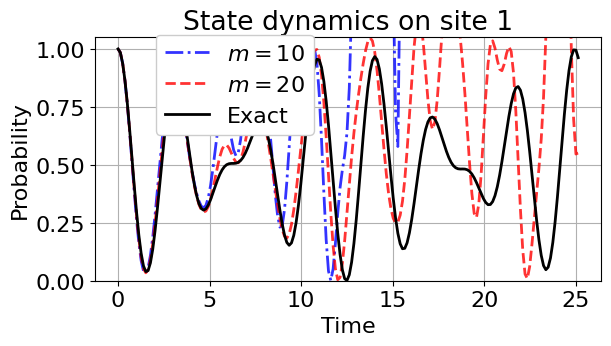

In [ ]:
# Plot state dynamics over one particular site
site = 0
path = base_path + "2-site-coupling-state_dynm_site1.pdf"

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    evo_matrix_trot_1[:, site],
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_1}$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_2[:, site],
    "r--",
    linewidth=2,
    label=rf"$m={trotter_steps_2}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times, n_evo_matrix[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.tight_layout()
plt.title("State dynamics on site " + str(site+1))
plt.tight_layout()
plt.savefig(path)
plt.show()

100%|██████████| 4/4 [04:16<00:00, 64.24s/it]


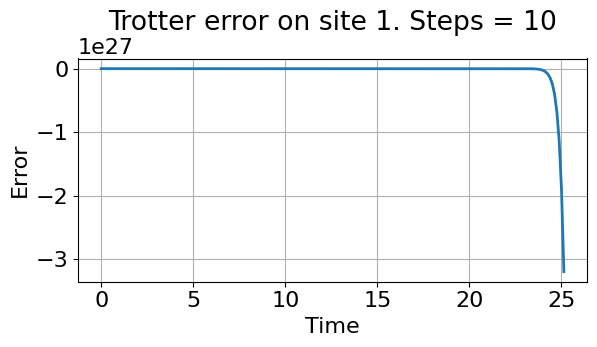

In [ ]:
# Number of trotter steps
trotter_steps_error = 10
path = base_path + "2-site-coupling-trotter_error_site1.pdf"

# Calculate each number operator's expectation value at each time point
evo_matrix_trot_error = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error)

# Plot state dynamics over one particular site
site = 0

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    n_evo_matrix[:, site]-evo_matrix_trot_error[:, site],
    linewidth=2
)

plt.xlabel("Time")
plt.ylabel("Error")
plt.grid()
plt.title("Trotter error on site " + str(site+1) + f". Steps = {trotter_steps_error}")
plt.tight_layout()
plt.savefig(path)
plt.show()

### Generate circuit diagram

In [26]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

from functions import compute_U_trot

num_sites = 4
tc = 0.5
eps = np.ones(num_sites)
phi = 2*np.pi
phiL = -phi / 2
phiR = phi / 2
delta = np.array([np.exp(1j * phiL), np.exp(1j * phiR)])
t = np.ones(2)

H = compute_H_secondquant_normal(eps, tc, t, delta)
U1 = compute_U_trot(H, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/2-site-coupling-circuit.tex", "w") as f:
    f.write(latex_code)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \qw & \qw & \qw & \qw & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{2\pi})}_<<<{0} & \gate{\mathrm{R_Z}\,(\mathrm{-\pi})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \qw & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{\frac{\pi}{2}})}_<<<{0} & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{\frac{\pi}{2}})}_<<<{0} & \ghost{\mathrm{R_{YY}}\,(\mathrm{2\pi})}_<<<{1} & \gate{\mathrm{R_Z}\,(\mathrm{-\pi})} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{2\pi})}_<<<{0} & \gate{\mathrm{R_Z}\,(\mathrm{-\pi})} & \ghost{\mathrm{R_{XX}}\,(\mathrm{\frac{\pi}{2}})}_<<<{1} & \ghost{\mathrm{R_{YY}}\,(\mathrm{\frac{\pi}{2}})}_<<<{1} & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{3} :  } & \lstick{{q}_{3} :  } & \ghost{\mathrm{R_{YY}}

In [27]:
H

PauliSumOp(SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIYY', 'IYYI', 'IXXI', 'IZII', 'ZIII', 'YYII'],
              coeffs=[ 2.  +0.j, -0.5 +0.j, -0.5 +0.j,  1.  +0.j,  0.25+0.j,  0.25+0.j,
 -0.5 +0.j, -0.5 +0.j,  1.  +0.j]), coeff=1.0)